This feature selection notebook does a filter followed by a wrapper for a binary dependent variable (binary classification). It's capable of doing the filter on more than one file. The variable files are called vars1.csv, vars2.csv ... Or you can make the input file name(s) anything you want.

The filter runs separately on each vars file and keeps the top num_filter variables from each file. If there are more than one vars files we'll again select the top num_filter variables across all the vars.csv files.

If balance = 0 the entire files are used. If balance != 0 then balance is the RATIO OF BADS TO GOODS retained for the rest of the feature selection. We keep all the rare class (bads) and downsample the goods. I think in general it's better to keep balance = 0.

I've got an annoying warning message from the wrapper and I can't figure out how to get rid of it. If anybody figures this out please send a message to stevecoggeshall@gmail.com

In [41]:
!pip install mlxtend

Defaulting to user installation because normal site-packages is not writeable


In [42]:
!pip install 'lightgbm[pandas]'

Defaulting to user installation because normal site-packages is not writeable


In [43]:
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable


In [44]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
%matplotlib inline
start_time = dt.datetime.now()

In [192]:
# set some parameters
num_files = 1
# I recommend set num_filter to be about 10 to 20% of the original # variables
num_filter = 80
# I recommend set num_wrapper to be about 50, then look for a saturation of the model performance as variables are added
# Then you can run it again with num_wrapper just a bit above this saturation point, not more than about twice this saturation number
num_wrapper = 20
balance = 0
detect_rate = .03
index_name = 'Recnum'
y_name = 'Fraud'
good_label = 0
bad_label = 1

## Run a filter on all the files

In [193]:
%%time
filter_score_df_list = []
for i in range(num_files):
#     file_name = "vars"+str(i+1)+'.csv'
    file_name = 'candidate_variables_smaller.csv'
    df = pd.read_csv(file_name)
    print("********** working on",file_name,"size is",df.shape)
    df = df.set_index(index_name) 
    df = df[df.index <= 85264] # remove the last two months as the out-of-time data (OOT)
    df = df[df.index >= 3466] # remove the first 2 weeks of records since their variables aren't well formed
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    if(balance != 0):
        if(i == 0):
            num_goods_desired = int(
                min(num_goods,num_bads*balance))
            goods = goods.sample(n=num_goods_desired,random_state=1)
            goods_keep = list(goods.index)
            goods_keep.sort()
    
        if(i > 0):
            goods = goods.loc[goods_keep] 
            
    df_sampled = pd.concat([goods,bads])
    df_sampled.sort_index(inplace=True)
    filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
    filter_score.columns = ['variable','filter score']   
    j = 0
    for column in df_sampled:
        filter_score.loc[j,'variable'] = column
        filter_score.loc[j,'filter score'] = sps.ks_2samp(goods[column],bads[column])[0]
        j = j+1
        if j%100 == 0:
            print(j)

    filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
    vars_keep = list(filter_score['variable'][1:num_filter+1]) 
    print(file_name,filter_score.head(20))
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        df_top = df_sampled.filter(vars_keep, axis=1)
            
    if(i > 0): # if more than one variable file we use this loop
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top,data_new_top], axis=1)

    filter_score_df_list.append(filter_score)
    
    del goods # delete these before starting the next file, if any
    del bads
    gc.collect()
filter_score = pd.concat(filter_score_df_list)

********** working on candidate_variables_smaller.csv size is (97496, 1330)
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
candidate_variables_smaller.csv                       variable  filter score
1                        Fraud      1.000000
28             Cardnum_total_3      0.621932
19             Cardnum_total_1      0.619658
10             Cardnum_total_0      0.591318
15             Cardnum_count_1      0.567429
37             Cardnum_total_7      0.564245
24             Cardnum_count_3      0.563356
586           Card_dow_total_7      0.542303
17               Cardnum_max_1      0.532080
33             Cardnum_count_7      0.526897
8                Cardnum_max_0      0.525418
6              Cardnum_count_0      0.516123
595          Card_dow_total_14      0.511203
26               Cardnum_max_3      0.501170
46            Cardnum_total_14      0.494375
584             Card_dow_max_7      0.486177
860      Cardnum_vdratio_1by14      0.485431
904  Cardnum_variability_m

In [194]:
filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
filter_score.reset_index(drop=True,inplace=True)

In [195]:
filter_score.head(30)

,variable,filter score
0,Fraud,1.000000
1,Cardnum_total_3,0.621932
2,Cardnum_total_1,0.619658
3,Cardnum_total_0,0.591318
4,Cardnum_count_1,0.567429
5,Cardnum_total_7,0.564245
6,Cardnum_count_3,0.563356
7,Card_dow_total_7,0.542303
8,Cardnum_max_1,0.532080
9,Cardnum_count_7,0.526897


In [196]:
filter_score.tail(10)

,variable,filter score
1320,card_merch_unique_count_for_card_state_30,0.000163
1321,merch_zip_unique_count_for_merch_state_60,0.000138
1322,Card_Merchdesc_unique_count_for_state_des_1,0.000125
1323,card_merch_unique_count_for_card_state_14,0.000100
1324,merch_zip_unique_count_for_merch_state_30,0.000100
1325,card_merch_unique_count_for_card_state_7,0.000088
1326,card_merch_unique_count_for_card_state_3,0.000063
1327,merch_zip_unique_count_for_merch_state_14,0.000025
1328,merch_zip_unique_count_for_merch_state_7,0.000013
1329,card_merch_unique_count_for_Cardnum_1,0.000000


In [197]:
filter_score.shape

(1330, 2)

In [198]:
filter_score.head(80).to_csv('filter_top.csv')
vars_keep = list(filter_score['variable'][num_files:num_filter+3])
print(i,' vars_keep:',vars_keep)

0  vars_keep: ['Cardnum_total_3', 'Cardnum_total_1', 'Cardnum_total_0', 'Cardnum_count_1', 'Cardnum_total_7', 'Cardnum_count_3', 'Card_dow_total_7', 'Cardnum_max_1', 'Cardnum_count_7', 'Cardnum_max_0', 'Cardnum_count_0', 'Card_dow_total_14', 'Cardnum_max_3', 'Cardnum_total_14', 'Card_dow_max_7', 'Cardnum_vdratio_1by14', 'Cardnum_variability_max_0', 'Card_dow_count_7', 'Cardnum_actual/toal_0', 'Card_dow_vdratio_0by14', 'Cardnum_variability_max_1', 'Cardnum_unique_count_for_card_state_1', 'Cardnum_unique_count_for_card_zip_1', 'Card_dow_total_30', 'Cardnum_unique_count_for_Merchnum_1', 'Card_dow_max_14', 'Card_dow_vdratio_0by7', 'Cardnum_vdratio_1by7', 'Cardnum_unique_count_for_card_state_3', 'Cardnum_unique_count_for_card_zip_3', 'Cardnum_unique_count_for_Merchnum_3', 'Cardnum_actual/toal_1', 'Card_dow_unique_count_for_merch_state_1', 'Card_dow_unique_count_for_Card_Merchdesc_1', 'Card_dow_unique_count_for_state_des_1', 'Card_dow_unique_count_for_merch_zip_1', 'Cardnum_unique_count_for_

In [199]:
vars_keep_df = pd.DataFrame({'col':vars_keep})
vars_keep_df.to_csv('vars_keep_filter.csv',index=False)
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

,Cardnum_total_3,Cardnum_total_1,Cardnum_total_0,Cardnum_count_1,Cardnum_total_7,Cardnum_count_3,Card_dow_total_7,Cardnum_max_1,Cardnum_count_7,Cardnum_max_0,...,Card_dow_unique_count_for_state_des_14,Card_dow_unique_count_for_Card_Merchdesc_14,Cardnum_unique_count_for_card_zip_30,card_state_total_3,card_state_total_1,Card_dow_unique_count_for_merch_zip_30,Card_dow_unique_count_for_merch_state_30,Cardnum_avg_0,Cardnum_unique_count_for_Merchnum_30,Cardnum_total_amount_1_by_14
Recnum,,,,,,,,,,,,,,,,,,,,,
3466,1964.73,1551.02,333.47,3,3591.53,7,333.47,930.41,9,333.47,...,1,1,13,333.47,333.47,1,1,333.470,13,0.013195
3467,834.91,660.87,4.37,2,997.73,34,109.97,656.50,72,4.37,...,5,5,2,178.41,4.37,1,1,4.370,3,0.039784
3468,8459.94,2904.08,271.93,7,9674.14,14,271.93,1380.45,17,271.93,...,1,1,20,955.00,582.94,1,1,271.930,21,0.014012
3469,838.53,664.49,7.99,3,1001.35,35,113.59,656.50,73,4.37,...,5,5,2,182.03,7.99,1,1,3.995,3,0.039881
3470,16.28,16.28,16.28,1,16.28,1,16.28,16.28,1,16.28,...,1,1,1,16.28,16.28,1,1,16.280,1,0.071429


In [200]:
df_keep.shape

(81476, 80)

In [201]:
Y.head()

,Fraud
Recnum,
3466,0
3467,0
3468,0
3469,0
3470,0


In [202]:
Y = Y.values.ravel()
Y_save = Y.copy()

In [203]:
# Y = np.array(Y)
X = df_keep
print(Y)

[0 0 0 ... 0 0 0]


In [204]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 2:47:03.535193


In [205]:
print(X.shape,Y.shape)

(81476, 80) (81476,)


In [206]:
print(type(X),type(Y))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [207]:
# I'd like to define a scoring for the wrapper that's KS, but I haven't gotten around to this yet.
# def KSscore(classifier, x,y)

In [208]:
def fdr(classifier, x, y, cutoff=0.03):
    # Calculates FDR score for the given classifier on dataset x and y with cutoff value
    return fdr_prob(y, classifier.predict_proba(x), cutoff)

def fdr_prob(y, y_prob, cutoff=0.03):
    if len(y_prob.shape) > 1:  # Check if y_prob is multi-dimensional
        y_prob = y_prob[:, -1]  # Use the last column if it's for the positive class
    y_prob = y_prob.flatten()  # Ensure y_prob is 1D
    num_fraud = np.sum(y == 1)  # Count the total number of frauds

    # Sort the proba list from high to low while retaining the true (not predicted) fraud label
    sorted_prob = np.array(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_index = int(len(y) * cutoff)  # Calculate index for cutoff
    cutoff_bin = sorted_prob[:cutoff_index, 1]  # Get labels up to the cutoff

    # Return the FDR score (#fraud_in_cutoff / #total_fraud)
    return np.sum(cutoff_bin == 1) / num_fraud if num_fraud > 0 else 0

## Run a wrapper on the remaining top variables

In [209]:
# This is a parallel running parameter. You can try it set to -1, but sometimes the data is too large to
# be divided into that many threads and the next cell quits. A safe value is 1 for no parallelization but it 
# the runs slower. You might experiment to see how big you can set this for this data set on your machine.
njobs = -1

In [210]:
%%time
import warnings 
warnings.filterwarnings("ignore") 
# If you're doing forward selection it's enough to stop at num_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get a sorted list of num_wrapper variables.

nfeatures = len(X.columns)
clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
#clf = LGBMClassifier(n_estimators=10,num_leaves=3) # simple, fast nonlinear model for the wrapper
#sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=0,scoring=fdr,cv=2,n_jobs=njobs) # use for forward selection
sfs = SFS(clf,k_features=1,forward=False,verbose=0,scoring=fdr,cv=4,n_jobs=-1) # use for backward selection
sfs.fit(X,Y)

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
/home/rchatterjee/.local/lib/python3.9/site-packages/sklearn/model_selection/_valida

CPU times: user 45.7 s, sys: 12.5 s, total: 58.2 s
Wall time: 45min 33s


SequentialFeatureSelector(cv=4,
                          estimator=RandomForestClassifier(n_estimators=5),
                          forward=False, k_features=(1, 1), n_jobs=-1,
                          scoring=<function fdr at 0x7f9b4b9ba670>)

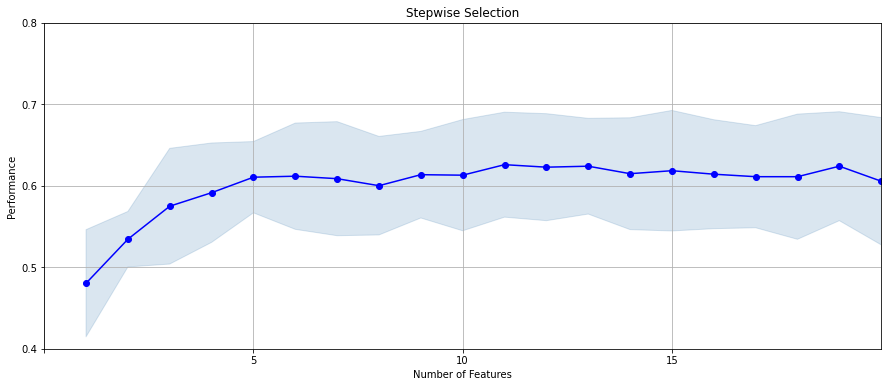

In [211]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
# plt.xticks(np.arange(0, len(X.columns), step=5))
plt.xticks(np.arange(0, num_wrapper, step=5))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([.4,.8])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('performance_nvars.png')
plt.show()

In [212]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [213]:
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(ordered_vars_FS.loc[i+1,'feature_names'])[0])
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])))[0]
# You might also need this following line. It converts a list to a string
#         ordered_vars_FS.loc[i+1,'variable name'] = ordered_vars_FS.loc[i+1,'variable name'][0]

In [214]:
ordered_vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,add variables in this order,variable name
80,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.597051597051597, 0.6044226044226044, 0.4705...",0.578555,"(Cardnum_total_3, Cardnum_total_1, Cardnum_tot...",0.103617,0.06464,0.03732,80.0,Cardnum_total_30
79,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.6191646191646192, 0.6363636363636364, 0.504...",0.608612,"(Cardnum_total_3, Cardnum_total_1, Cardnum_tot...",0.101113,0.063078,0.036418,79.0,Cardnum_avg_0
78,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.6265356265356266, 0.6068796068796068, 0.475...",0.596957,"(Cardnum_total_3, Cardnum_total_1, Cardnum_tot...",0.120079,0.074909,0.043249,78.0,Cardnum_unique_count_for_card_state_30
77,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.597051597051597, 0.6363636363636364, 0.4852...",0.592668,"(Cardnum_total_3, Cardnum_total_1, Cardnum_tot...",0.10442,0.065141,0.037609,77.0,Card_dow_variability_max_7
76,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.6216216216216216, 0.6167076167076168, 0.487...",0.603087,"(Cardnum_total_3, Cardnum_total_1, Cardnum_tot...",0.115462,0.072029,0.041586,76.0,Card_dow_unique_count_for_merch_state_7
...,...,...,...,...,...,...,...,...,...
5,"(6, 22, 64, 69, 73)","[0.6191646191646192, 0.6461916461916462, 0.536...",0.610457,"(Card_dow_total_7, Cardnum_unique_count_for_ca...",0.070051,0.0437,0.02523,5.0,Card_dow_unique_count_for_state_des_7
4,"(6, 22, 69, 73)","[0.5847665847665847, 0.6633906633906634, 0.497...",0.591451,"(Card_dow_total_7, Cardnum_unique_count_for_ca...",0.097697,0.060947,0.035188,4.0,Card_dow_total_7
3,"(22, 69, 73)","[0.5773955773955773, 0.6363636363636364, 0.458...",0.574886,"(Cardnum_unique_count_for_card_zip_1, Cardnum_...",0.113725,0.070946,0.040961,3.0,Cardnum_vdratio_0by14
2,"(22, 73)","[0.5700245700245701, 0.5552825552825553, 0.480...",0.534391,"(Cardnum_unique_count_for_card_zip_1, card_sta...",0.054528,0.034016,0.019639,2.0,card_state_total_3


In [215]:
ordered_vars_FS.to_csv('Wrapper_selection_info.csv', index=False)

In [216]:
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()
vars_keep.to_csv('final_vars_list.csv',index=False)
vars_keep

80                           Cardnum_total_30
79                              Cardnum_avg_0
78     Cardnum_unique_count_for_card_state_30
77                 Card_dow_variability_max_7
76    Card_dow_unique_count_for_merch_state_7
                       ...                   
5       Card_dow_unique_count_for_state_des_7
4                            Card_dow_total_7
3                       Cardnum_vdratio_0by14
2                          card_state_total_3
1         Cardnum_unique_count_for_card_zip_1
Name: variable name, Length: 80, dtype: object

In [217]:
filter_score.set_index('variable',drop=True,inplace=True)
filter_score = filter_score.iloc[1:,:]
filter_score

,filter score
variable,
Cardnum_total_3,0.621932
Cardnum_total_1,0.619658
Cardnum_total_0,0.591318
Cardnum_count_1,0.567429
Cardnum_total_7,0.564245
...,...
card_merch_unique_count_for_card_state_7,0.000088
card_merch_unique_count_for_card_state_3,0.000063
merch_zip_unique_count_for_merch_state_14,0.000025


In [218]:
vars_keep_sorted = pd.DataFrame(vars_keep_list)
vars_keep_sorted.columns=['variable']
vars_keep_sorted.set_index('variable',drop=True,inplace=True)
vars_keep_sorted.head()

""
variable
Cardnum_total_30
Cardnum_avg_0
Cardnum_unique_count_for_card_state_30
Card_dow_variability_max_7
Card_dow_unique_count_for_merch_state_7


In [219]:
vars_keep_sorted = pd.concat([vars_keep_sorted,filter_score],axis=1,join='inner')

In [220]:
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted['index'] = vars_keep_sorted['index'] + 1
vars_keep_sorted.rename(columns={'index':'wrapper order'},inplace=True)
vars_keep_sorted.to_csv('vars_keep_sorted.csv',index=False)
vars_keep_sorted

,wrapper order,variable,filter score
0,1,Cardnum_total_30,0.410799
1,2,Cardnum_avg_0,0.363150
2,3,Cardnum_unique_count_for_card_state_30,0.388385
3,4,Card_dow_variability_max_7,0.403699
4,5,Card_dow_unique_count_for_merch_state_7,0.417904
...,...,...,...
75,76,Card_dow_unique_count_for_state_des_7,0.396572
76,77,Card_dow_total_7,0.542303
77,78,Cardnum_vdratio_0by14,0.379037
78,79,card_state_total_3,0.368079


In [221]:
vars_keep_list.append(index_name)
vars_keep_list.append(y_name)
vars_keep_list

['Cardnum_total_30',
 'Cardnum_avg_0',
 'Cardnum_unique_count_for_card_state_30',
 'Card_dow_variability_max_7',
 'Card_dow_unique_count_for_merch_state_7',
 'Card_dow_count_30',
 'Cardnum_count_1_by_14',
 'Cardnum_count_1_by_30_sq',
 'Cardnum_unique_count_for_card_state_3',
 'Cardnum_unique_count_for_Merchnum_1',
 'Cardnum_unique_count_for_card_state_1',
 'Cardnum_count_14',
 'Card_dow_day_since',
 'Card_dow_vdratio_0by7',
 'Cardnum_total_7',
 'Card_dow_unique_count_for_Card_Merchdesc_7',
 'Card_dow_max_60',
 'Card_dow_unique_count_for_merch_zip_7',
 'Cardnum_actual/toal_0',
 'Cardnum_count_0',
 'Cardnum_unique_count_for_card_state_14',
 'Cardnum_unique_count_for_card_zip_7',
 'Card_dow_count_7',
 'Card_dow_vdratio_0by14',
 'Cardnum_max_1',
 'card_state_total_1',
 'Cardnum_unique_count_for_card_zip_30',
 'Card_dow_unique_count_for_Card_Merchdesc_14',
 'Cardnum_total_3',
 'Cardnum_unique_count_for_Merchnum_7',
 'Card_dow_unique_count_for_Card_Merchdesc_1',
 'Cardnum_variability_max_3',

In [222]:
filter_score

,filter score
variable,
Cardnum_total_3,0.621932
Cardnum_total_1,0.619658
Cardnum_total_0,0.591318
Cardnum_count_1,0.567429
Cardnum_total_7,0.564245
...,...
card_merch_unique_count_for_card_state_7,0.000088
card_merch_unique_count_for_card_state_3,0.000063
merch_zip_unique_count_for_merch_state_14,0.000025


In [223]:
%%time
df = pd.read_csv(file_name)
df.shape

CPU times: user 14.5 s, sys: 2.34 s, total: 16.9 s
Wall time: 16.9 s


(97496, 1330)

In [224]:
df_keep = df.filter(vars_keep_list, axis=1)
# df_keep = df[df.index.isin(vars_keep_list)]
print(df_keep.shape)

(97496, 82)


In [225]:
df_keep.to_csv('vars_final.csv',index=False)

In [226]:
print("duration: ", dt.datetime.now() - start_time)

duration:  3:32:58.060409


In [227]:
%pwd

'/home/rchatterjee/private/Fraud Analytics'

In [2]:
import pandas as pd

In [5]:
df = pd.read_csv('vars_keep_sorted.csv')

In [6]:
df

,wrapper order,variable,filter score
0,1,Cardnum_unique_count_for_card_state_1,0.476067
1,2,card_state_total_3,0.368079
2,3,Cardnum_max_7,0.410589
3,4,Cardnum_vdratio_1by14,0.485431
4,5,Card_dow_unique_count_for_merch_state_1,0.447357
5,6,Card_dow_vdratio_0by14,0.479086
6,7,Cardnum_count_7,0.526897
7,8,Card_dow_total_30,0.474759
8,9,Cardnum_total_14,0.494375
9,10,Card_dow_count_7,0.482384
